In [1]:

import pathlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [2]:
folder = path = pathlib.Path(os.getcwd())
folder = folder.parent.joinpath('data/amazon').joinpath('AMZN.csv')
str(folder)
df = pd.read_csv(str(folder))


In [3]:
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'High'])

for i in range(0, len(df)):
    new_data['Date'][i] = df['Date'][i]
    new_data['High'][i] = df['High'][i]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True) # So that Date is the index

    

In [4]:
data_set = new_data.values
data_set

array([[383.0],
       [379.98999],
       [376.73999],
       ...,
       [2098.530029],
       [2135.600098],
       [2185.949951]], dtype=object)

In [5]:
# train test split
train_data = data_set[0:856, :]
train_data
valid_data = data_set[856:, :]

In [6]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale between 0 and 1
scaled_data = scaler.fit_transform(data_set)

In [7]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
# Create and fit the LTSM network
model = Sequential () # Get sequential output
# Define the input layer
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=60))
# Nodes in the output layer. Since we're predicting one data, we only use Dense(1)
model.add(Dense(1))

# Fit the data
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=3)

# Predicting 246 values, using past 60 from train data
inputs = new_data[len(new_data) - len(valid_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Prepare test data (to verify against)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i - 60:i, 0])
X_test = np.array(X_test) 

X_test

Epoch 1/1


array([[0.59980715, 0.59276406, 0.62593479, ..., 0.73808381, 0.7406079 ,
        0.75399416],
       [0.59276406, 0.62593479, 0.64059964, ..., 0.7406079 , 0.75399416,
        0.75974762],
       [0.62593479, 0.64059964, 0.65973385, ..., 0.75399416, 0.75974762,
        0.76358326],
       ...,
       [0.77628064, 0.77970847, 0.77352514, ..., 0.93047868, 0.93666202,
        0.92854983],
       [0.77970847, 0.77352514, 0.76889036, ..., 0.93666202, 0.92854983,
        0.95182281],
       [0.77352514, 0.76889036, 0.7661845 , ..., 0.92854983, 0.95182281,
        0.97225215]])

In [9]:
X_test.shape

(401, 60)

In [10]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# X_test.shape
# print(" ")
# X_test

array([[[0.59980715],
        [0.59276406],
        [0.62593479],
        ...,
        [0.73808381],
        [0.7406079 ],
        [0.75399416]],

       [[0.59276406],
        [0.62593479],
        [0.64059964],
        ...,
        [0.7406079 ],
        [0.75399416],
        [0.75974762]],

       [[0.62593479],
        [0.64059964],
        [0.65973385],
        ...,
        [0.75399416],
        [0.75974762],
        [0.76358326]],

       ...,

       [[0.77628064],
        [0.77970847],
        [0.77352514],
        ...,
        [0.93047868],
        [0.93666202],
        [0.92854983]],

       [[0.77970847],
        [0.77352514],
        [0.76889036],
        ...,
        [0.93666202],
        [0.92854983],
        [0.95182281]],

       [[0.77352514],
        [0.76889036],
        [0.7661845 ],
        ...,
        [0.92854983],
        [0.95182281],
        [0.97225215]]])

In [11]:
high_price = model.predict(X_test)
high_price = scaler.inverse_transform(high_price)

In [12]:
rms = np.sqrt(np.mean(np.power((valid_data - high_price), 2)))
rms

65.83130788181991

f:\symbiosis\bfm\venv-finance-dash\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


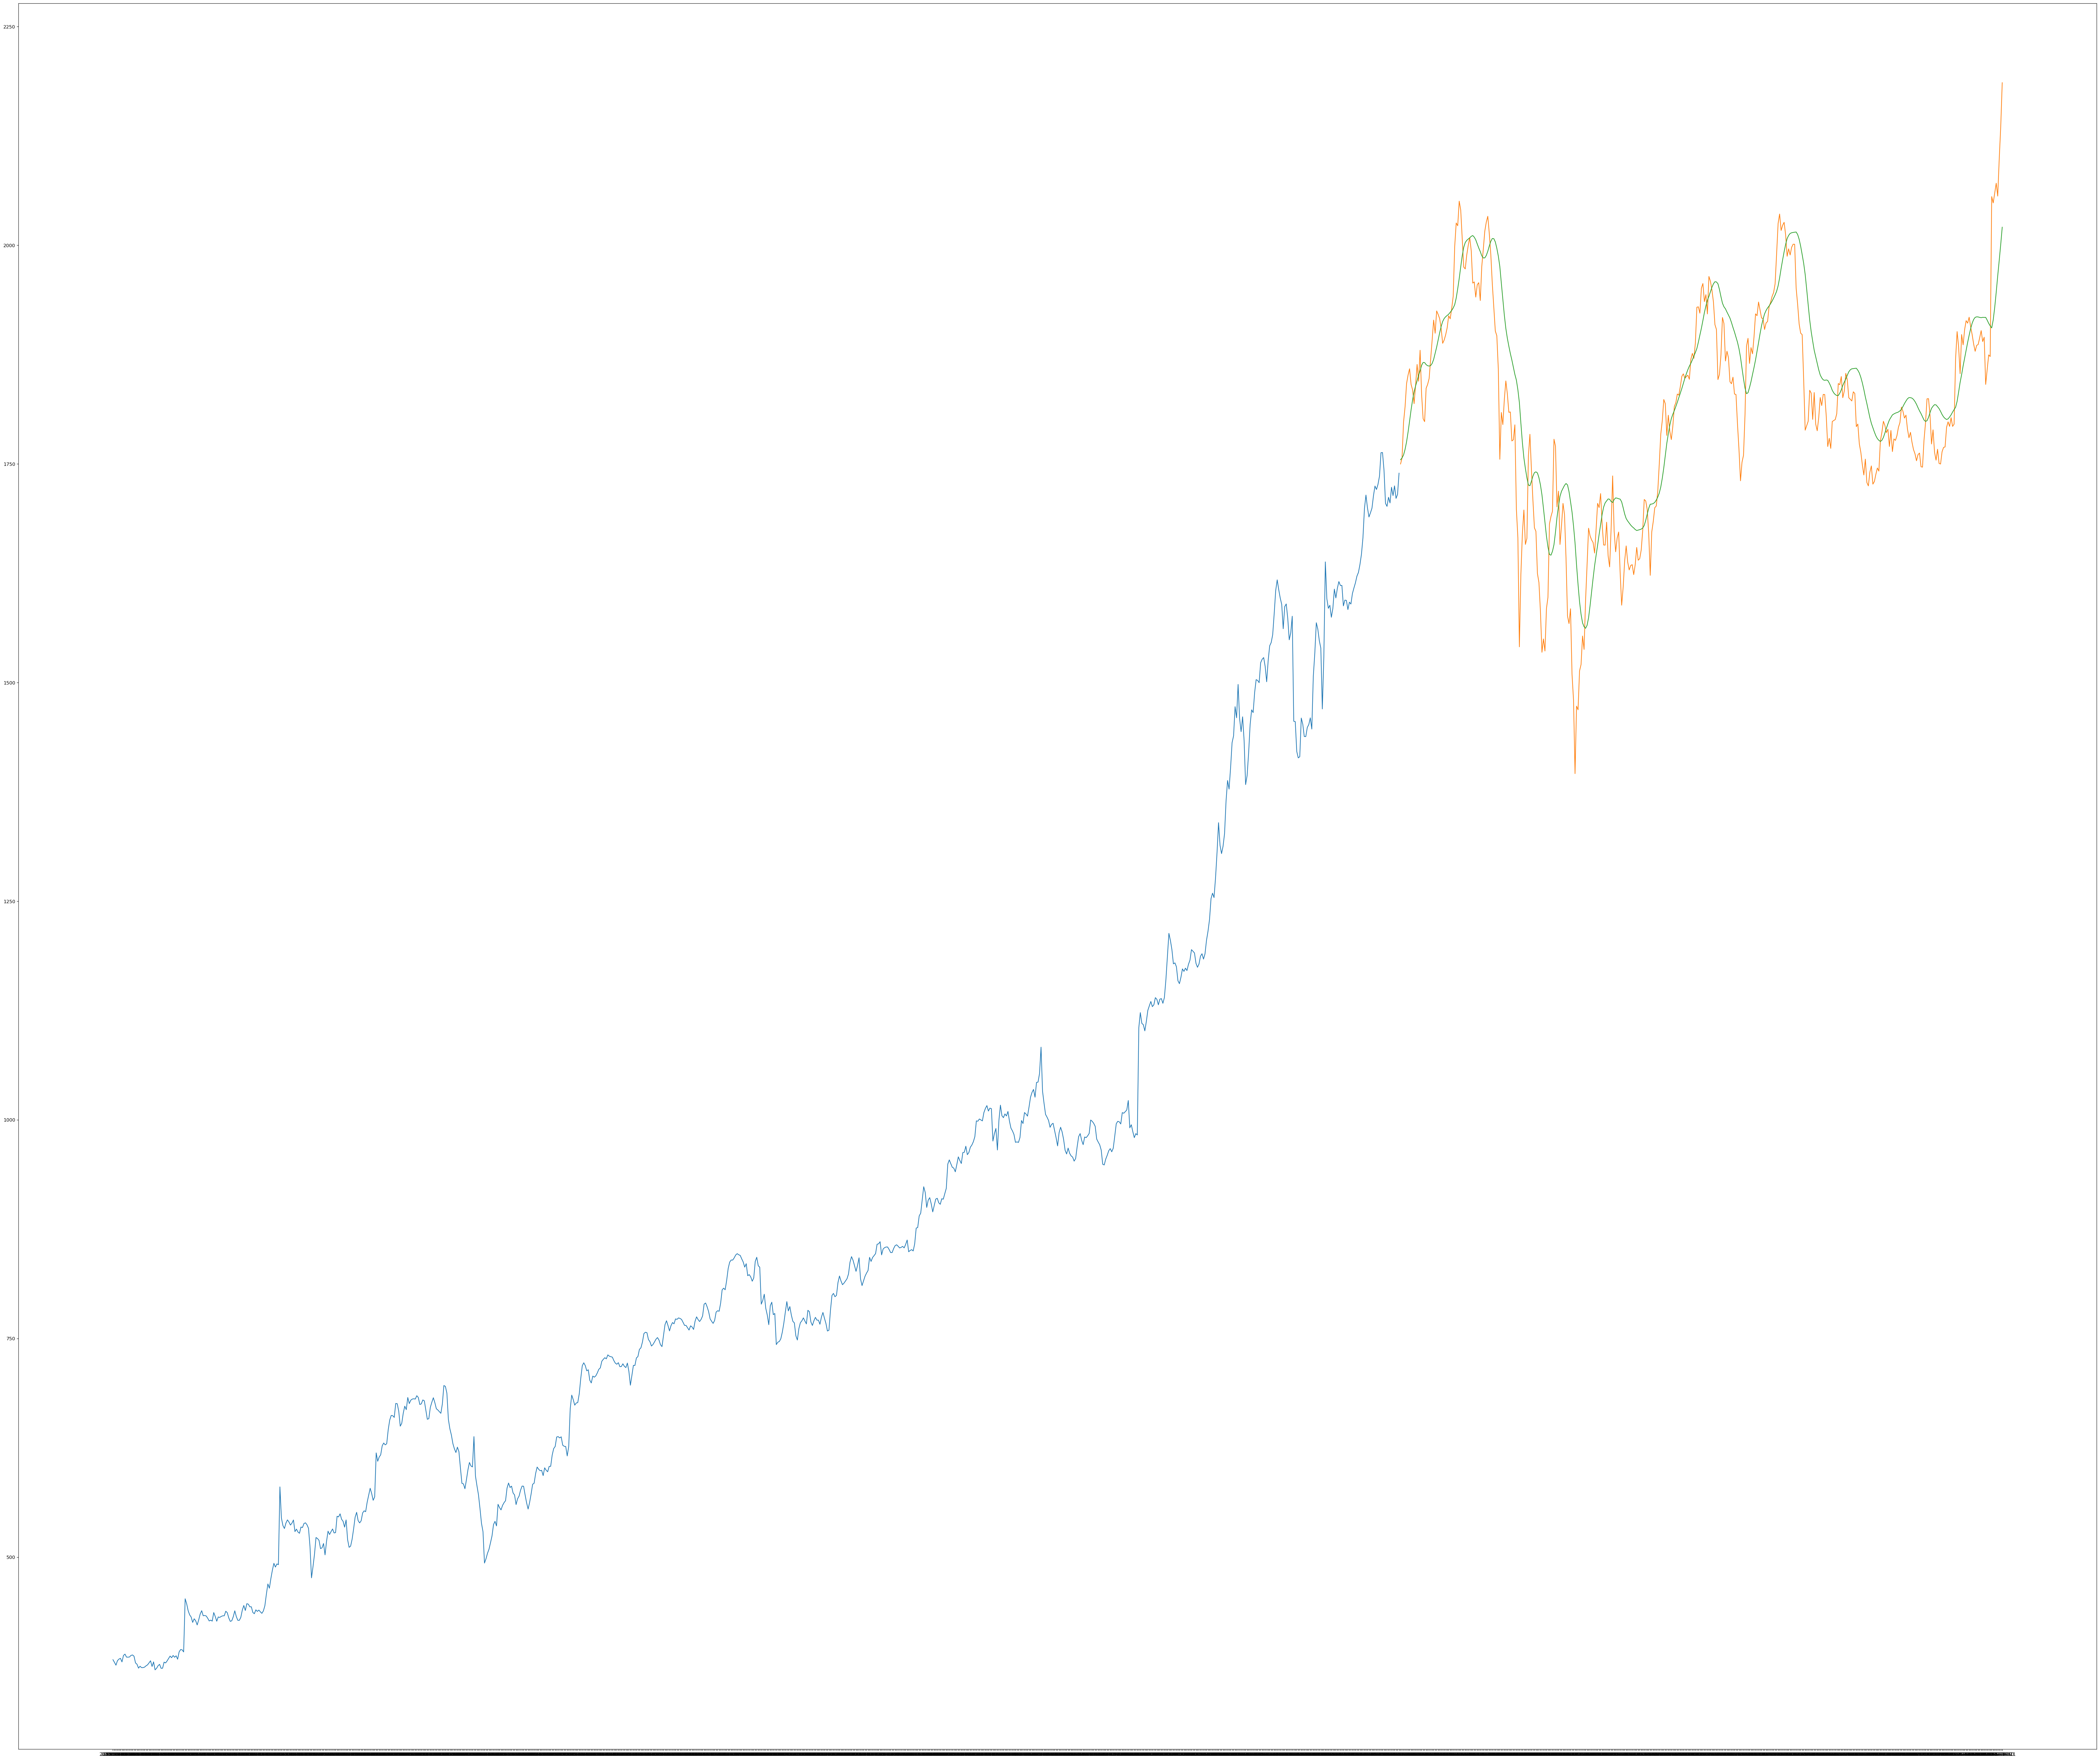

In [24]:
np.shape(valid_data)
train_data = new_data[:856]
valid_data = new_data[856:]
valid_data['predictions_high'] = high_price
plt.figure(figsize=(80, 69), dpi=120, facecolor='w', edgecolor='k')
plt.plot(train_data['High'])
plt.plot(valid_data[['High','predictions_high']])